In [1]:
% matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import us

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

#  Download data

In [3]:
query = """
WITH county_geo AS (
  SELECT  
    census_block.state_county_code, 
    AVG(census_block.land_area) AS area
  FROM broadband.census_block census_block
  GROUP BY census_block.state_county_code
),
internet_block AS (
  SELECT 
    block.*,
    CASE WHEN fcc.max_down IS NULL THEN 0 ELSE 1 END AS count_int_avail
  FROM broadband.census_block block
  LEFT JOIN broadband.fcc fcc
      ON block.block_code = fcc.block_code
),
internet_county AS (
  SELECT 
    state_county_code,
    MAX(state_abbr) AS state_abbr,
    MAX(state) AS state,
    MAX(county) AS county,
    AVG(count_int_avail) AS int_avail_per
  FROM internet_block
  GROUP BY state_county_code
)

SELECT
  internet_county.state_county_code, 
  internet_county.state_abbr,
  internet_county.state,
  internet_county.county,
  internet_county.int_avail_per,
  income.census_income_2016 AS income,
  housing.total_housing_units2010census / county_geo.area AS housing_density,
  population.census_population_2010 / county_geo.area AS population_density,
  education.bachelor_or_higher
FROM internet_county
LEFT JOIN county_geo
  ON internet_county.state_county_code = county_geo.state_county_code
LEFT JOIN broadband.census_income income
  ON internet_county.state_county_code = income.state_county_code
LEFT JOIN broadband.census_housing housing
  ON internet_county.state_county_code = housing.state_county_code
LEFT JOIN broadband.census_population population
  ON internet_county.state_county_code = population.state_county_code
LEFT JOIN broadband.census_education education
  ON internet_county.state_county_code = education.state_county_code
"""

data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [5]:
# convert to sq miles
data.housing_density = data.housing_density *2.59*10**6
data.population_density = data.population_density *2.59*10**6

In [9]:
attrs = ['int_avail_per',
         'income',
         'housing_density',
         'population_density',
         'bachelor_or_higher']
data[attrs] = data[attrs].astype(np.float)

In [10]:
data.count()

state_county_code     3109
state_abbr            3109
state                 3109
county                3109
int_avail_per         3109
income                3079
housing_density       3109
population_density    3107
bachelor_or_higher    3107
dtype: int64

# Which state has the most broadband coverage?

In [26]:
internet_per = data.groupby('state').int_avail_per.mean().sort_values(ascending=False)

In [27]:
internet_per.head(10)

state
Wyoming                1.000000
Kansas                 0.993748
Connecticut            0.992981
Wisconsin              0.992597
Illinois               0.992586
Indiana                0.992445
Ohio                   0.990877
District of Columbia   0.990125
South Dakota           0.989456
Nebraska               0.987544
Name: int_avail_per, dtype: float64

# Which state has the least broadband coverage?

In [28]:
internet_per.tail(10)

state
Alabama       0.944347
Idaho         0.943630
Utah          0.941992
Georgia       0.929736
Oregon        0.925909
Arkansas      0.922731
Mississippi   0.921321
New Mexico    0.918434
Louisiana     0.902638
Nevada        0.839709
Name: int_avail_per, dtype: float64

# Which county has the least broadband coverage?

In [55]:
data.sort_values('int_avail_per').head(10)

,state_county_code,state_abbr,state,county,int_avail_per,income,housing_density,population_density,bachelor_or_higher,int_avail_type
2170,48301,TX,Texas,Loving County,0.092216,"39,221.000000",58.013079,95.141450,3.000000,no
2308,51181,VA,Virginia,Surry County,0.210751,"41,337.000000","12,050.066677","24,694.939200",22.800000,no
1610,32011,NV,Nevada,Eureka County,0.267165,"34,159.000000",462.542497,854.156080,16.600000,no
391,13007,GA,Georgia,Baker County,0.428082,"35,296.000000","3,594.289651","7,508.410160",11.000000,no
186,06091,CA,California,Sierra County,0.462222,"40,537.000000","4,738.240551","6,594.458499",19.800000,no
1589,35021,NM,New Mexico,Harding County,0.474255,"42,720.000000",247.497783,327.017032,25.800000,no
1300,30061,MT,Montana,Mineral County,0.475988,"33,617.000000","3,152.467786","5,442.711145",12.700000,no
1267,28055,MS,Mississippi,Issaquena County,0.535095,"22,883.000000","1,015.487140","2,549.598070",9.000000,NaN
1301,30039,MT,Montana,Granite County,0.539844,"36,868.000000","2,535.960676","2,766.911028",25.000000,NaN
357,13065,GA,Georgia,Clinch County,0.559275,"32,087.000000","7,821.966743","17,683.315571",14.400000,NaN


# Comparing the counties with and without internet in terms of 

1. income
2. housing density
3. population density
4. percent of population who holds bachelor or higher degree

In [40]:
data.loc[data.int_avail_per == 1, 'int_avail_type'] = 'yes'
data.loc[data.int_avail_per < 0.5, 'int_avail_type'] = 'no'
subset = data.dropna(subset=['int_avail_type'])

In [47]:
def plot_by_attr(attr):
    ax = subset[[attr, 'int_avail_type']].boxplot(by='int_avail_type', return_type='axes', figsize=(8, 6))
    plt.title(attr.title(), fontsize=16)
    plt.suptitle('')
    plt.xlabel('Internet Avaiability', fontsize=16)
    plt.ylabel(attr.title(), fontsize=16)
    plt.show()
    
    print(subset.groupby('int_avail_type')[attr].describe().T)

### Income

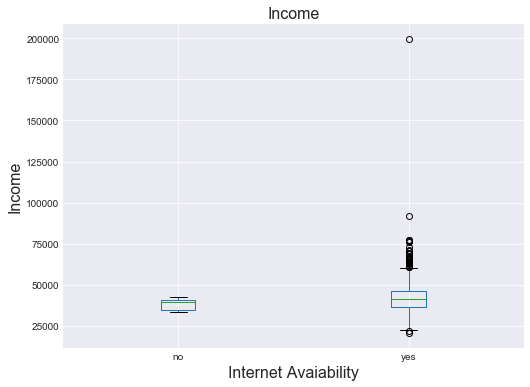

int_avail_type            no            yes
count               7.000000     548.000000
mean           38,126.714286  42,377.609489
std             3,708.197438  11,398.104908
min            33,617.000000  20,353.000000
25%            34,727.500000  36,384.250000
50%            39,221.000000  41,049.500000
75%            40,937.000000  45,996.000000
max            42,720.000000 199,635.000000


In [48]:
plot_by_attr('income')

Median income of the county without internet is \$39,221 and with \$41,049

**Teton County** has 100% internet coverage
- The county contains the Jackson Hole ski area
- Mean income is \$199,635

In [49]:
subset[subset.income > 199000]

,state_county_code,state_abbr,state,county,int_avail_per,income,housing_density,population_density,bachelor_or_higher,int_avail_type
3098,56039,WY,Wyoming,Teton County,1.000000,"199,635.000000","8,017.665611","13,324.605598",53.800000,yes


### Housing density

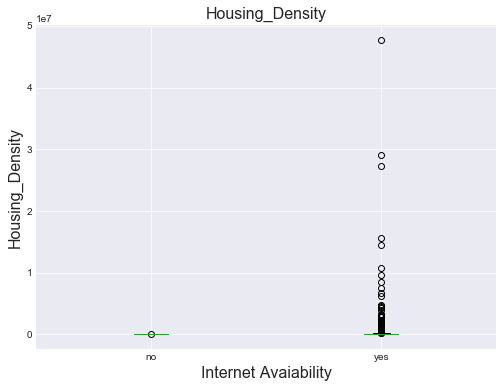

int_avail_type            no               yes
count               7.000000        555.000000
mean            3,471.874003    554,440.914604
std             4,211.357743  2,944,312.868679
min                58.013079        248.733858
25%               355.020140     10,720.185910
50%             3,152.467786     39,761.477906
75%             4,166.265101    130,472.324098
max            12,050.066677 47,715,350.611123


In [50]:
plot_by_attr('housing_density')

- There is a large difference between their median values 3,152.467786 units / ssq mi vs 39,761.477906 unites / sq mi
- There is a large difference between their std values 4,211.357743 units / ssq mi vs 2,944,312 unites / sq mi

Most dense area that has 100 % internet coverage is **Dallas County**

In [51]:
subset[subset.housing_density == subset.housing_density.max()]

,state_county_code,state_abbr,state,county,int_avail_per,income,housing_density,population_density,bachelor_or_higher,int_avail_type
2988,48113,TX,Texas,Dallas County,1.000000,"52,784.000000","47,715,350.611123","119,794,056.848635",29.700000,yes


# Population density

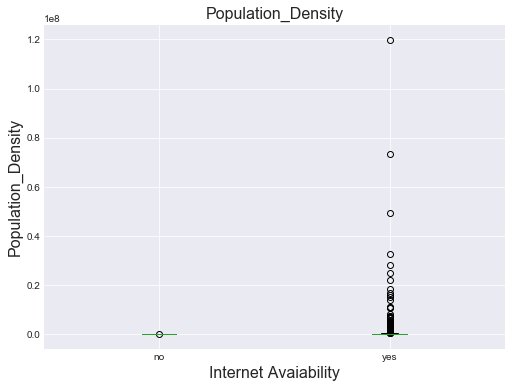

int_avail_type            no                yes
count               7.000000         555.000000
mean            6,502.404795   1,285,132.017682
std             8,604.290892   6,952,633.918533
min                95.141450         465.112093
25%               590.586556      22,485.434548
50%             5,442.711145      86,516.099823
75%             7,051.434329     304,918.488610
max            24,694.939200 119,794,056.848635


In [56]:
plot_by_attr('population_density')

Most dense area that has 100 % internet coverage is **Dallas County**

In [60]:
subset[subset.population_density == subset.population_density.max()]

,state_county_code,state_abbr,state,county,int_avail_per,income,housing_density,population_density,bachelor_or_higher,int_avail_type
2988,48113,TX,Texas,Dallas County,1.000000,"52,784.000000","47,715,350.611123","119,794,056.848635",29.700000,yes


### Percent of population who holds bachelor or higher degree

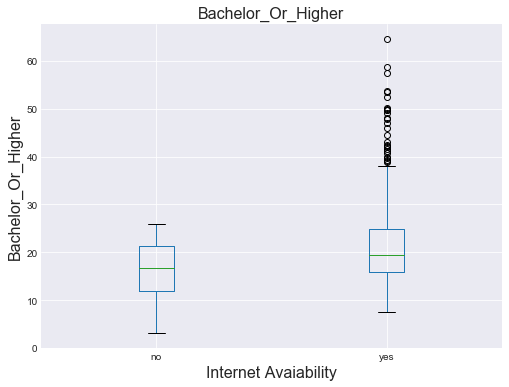

int_avail_type        no        yes
count           7.000000 555.000000
mean           15.957143  21.294414
std             7.766994   8.559471
min             3.000000   7.500000
25%            11.850000  15.800000
50%            16.600000  19.400000
75%            21.300000  24.800000
max            25.800000  64.600000


In [59]:
plot_by_attr('bachelor_or_higher')

Highest educated area that has 100 % internet coverage is **Los Alamos County in New Mexico**

In [61]:
subset[subset.bachelor_or_higher == subset.bachelor_or_higher.max()]

,state_county_code,state_abbr,state,county,int_avail_per,income,housing_density,population_density,bachelor_or_higher,int_avail_type
2886,35028,NM,New Mexico,Los Alamos County,1.000000,"65,494.000000","46,741.197284","100,431.468907",64.600000,yes
